# Воркшоп №8. Очистка даних, розвідувальний аналіз

Цей воркшоп виконує...

Перш за все, зчитаємо вміст файлу `data_flatfy_2019.csv`.

Кілька дисклеймерів:
- Цей датасет - реальні дані з сайту [Flatfy](https://flatfy.ua/) за осінь 2019 року
- Flatfy - агрегатор оголошень з сотень веб-порталів нерухомості. Тому, по-перше, **не всі дані коректні**, а по-друге, у стовпчику `geo` можете побачити велику кількість рядків російською. На жаль, у 2019 році статус кво був саме таким.
- Актуальні курси валют на момент публікації даних: Долар США - 24.81, Євро - 27.62.


In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt

In [127]:
df = pd.read_csv("data_flatfy_2019.csv", sep=",")

In [128]:
df.describe()

,Unnamed: 0,price,room_count,floor_count,floor,area_total,area_kitchen,area_living,ceiling_height
count,1.429891e+06,1.429891e+06,1.228421e+06,907008.000000,824366.000000,1.297139e+06,6.522570e+05,6.075900e+05,31962.000000
mean,7.149450e+05,4.710965e+05,2.336602e+00,10.084085,6.126484,1.565654e+04,1.015426e+03,1.108546e+03,4.184263
std,4.127741e+05,3.199913e+08,1.353071e+00,7.942468,5.489417,1.028469e+07,7.919497e+05,8.204598e+05,58.355461
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,4.000000e-02,6.000000e-02,1.000000e-02,0.010000
25%,3.574725e+05,1.250000e+04,1.000000e+00,4.000000,2.000000,4.400000e+01,8.000000e+00,2.000000e+01,2.700000
50%,7.149450e+05,3.250000e+04,2.000000e+00,9.000000,4.000000,6.000000e+01,1.100000e+01,3.500000e+01,2.800000
75%,1.072418e+06,7.000000e+04,3.000000e+00,16.000000,8.000000,9.000000e+01,1.580000e+01,5.000000e+01,3.000000
max,1.429890e+06,3.809687e+11,2.000000e+01,126.000000,123.000000,1.000000e+10,6.394977e+08,6.394977e+08,3200.000000


Погляньте, скільки категорій! Тут і продаж квартир, і оренда комерційної нерухомості, і ще купа різного. Аналізувати такий великий датасет складнувато, тож давайте сконцентруємось на **продажі квартир**. Обовʼязково переконайтетсь, що ви виділили усе, що треба! 

In [131]:
df_flats = df[
	df['section'].str.contains('квартира', na=False) &
	df['section'].str.contains('продаж|продажа', na=False)
]

Спершу розберемося з ціною. Створіть новий стовпчик з ціною нерухомості в **гривнях**.

In [132]:
rate = {
    "USD" : 24.81,
    "EUR" : 27.62,
    "UAH" : 1.0,
}
df_flats = df_flats.copy()
df_flats["price_UAH"] = df_flats.apply(lambda x: x["price"] * rate[x["currency"]], axis=1)

Прекрасно, з цим вже можна працювати! 

Спробуйте провести розвідувальний аналіз у кілька етапів:
- Прогляньте базові статистичні дані (середнє, квантилі etc.) по різних характеристиках
- Погляньте на можливі значення `room_count`, за потреби відсійте те, що не дуже має сенс аналізувати :)
- Викиньте дані, які __очевидно__ заповнено неправильно. Окрім того, застосуйте IQR-метод (k=1.5 або близький до цього, який вам подобається) для фільтрації неадекватних даних по площі.
- Проаналізуйте, чи є сенс використовувати IQR-метод для цін. Застосуйте його, якщо це має сенс.
- Використайте "ящики з вусами" та гістограми, щоб виділити факти про:
  - Взаємозалежність між площею та кількістю кімнат
  - Взаємозалежність між площею кухні та кількістю кімнат. Тут є цікавий момент, чи можете ви його побачити і зробити гіпотезу, чому так?
  - Розподіл вартості житла в залежності від кількості кімнат

In [133]:
df_flats["room_count"].value_counts()

room_count
2.0     243057
1.0     234241
3.0     199659
4.0      42826
5.0       8736
6.0       1901
7.0        560
8.0        208
10.0       165
9.0        125
12.0        23
11.0        13
17.0        10
15.0         8
16.0         4
20.0         3
13.0         3
14.0         3
18.0         1
Name: count, dtype: int64

In [134]:
df_flats = df_flats[df_flats["room_count"] < 12]

In [135]:
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [136]:

alt.Chart(df_flats).mark_bar().encode(
    x = "floor_count:Q",
    y = "count()",
).interactive()

alt.Chart(...)

In [137]:
df_flats = df_flats[df_flats["floor_count"] < 46]

In [138]:
df_flats = df_flats[df_flats["floor_count"] > df_flats["floor"]]

In [139]:
df_flats.describe() 

,Unnamed: 0,price,room_count,floor_count,floor,area_total,area_kitchen,area_living,ceiling_height,price_UAH
count,4.397250e+05,4.397250e+05,439725.000000,439725.000000,439725.000000,438504.000000,3.720370e+05,328634.000000,15582.000000,4.397250e+05
mean,7.191913e+05,1.491859e+05,2.104104,13.147870,6.825712,75.298832,4.868603e+01,36.855668,5.546490,1.953255e+06
std,4.127975e+05,6.201879e+05,1.009456,7.542035,5.637446,1069.465589,1.852839e+04,94.924274,83.517342,6.030812e+06
min,5.000000e+00,1.000000e+00,1.000000,2.000000,1.000000,0.710000,1.000000e-01,0.010000,0.010000,1.000000e+00
25%,3.566830e+05,3.000000e+04,1.000000,9.000000,3.000000,44.000000,8.000000e+00,19.000000,2.700000,7.070850e+05
50%,7.163370e+05,5.000000e+04,2.000000,10.000000,5.000000,60.000000,1.100000e+01,32.000000,2.900000,1.141260e+06
75%,1.081873e+06,9.500000e+04,3.000000,19.000000,9.000000,79.000000,1.500000e+01,45.000000,3.000000,1.984800e+06
max,1.429887e+06,1.215000e+08,11.000000,45.000000,41.000000,444444.000000,1.111111e+07,41674.000000,3200.000000,2.481000e+09


Нарешті, ще одне завдання. Використовуючи будь-який підхід, який вам до вподоби (звичайні функції, регулярні вирази тощо), спробуйте виділити з колонки гео дані про місто, а в ідеалі ще номер будинку і вулицю. Задача зовсім не легка, тому можете сконцентруватися на Києві, Харкові та Львові. 

Спробуйте проітеруватися над вашим алгоритмом декілька разів і перевірити, чи адекватні ті дані, які ви отримуєте.
І ще одне: тут немає мети виділити правильне місто зі 100% оголошень. У деяких ситуаціях цілком ок принести в жертву деяку кількість записів, якщо алгоритм при цьому буде достатньо простим.

<Axes: title={'center': 'price_UAH'}, xlabel='room_count'>

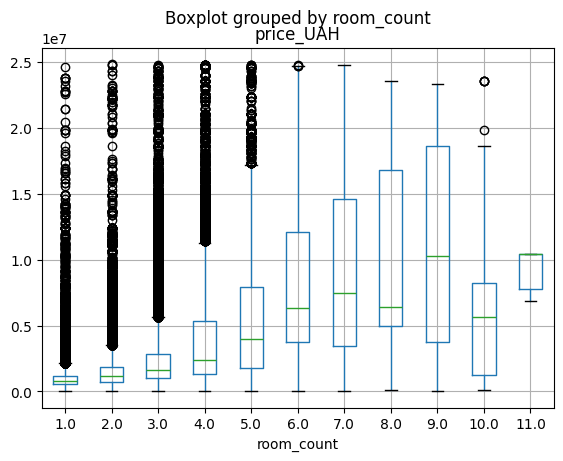

In [140]:
df_flats[df_flats["price"] < 1e6 ].boxplot(column="price_UAH", by="room_count")

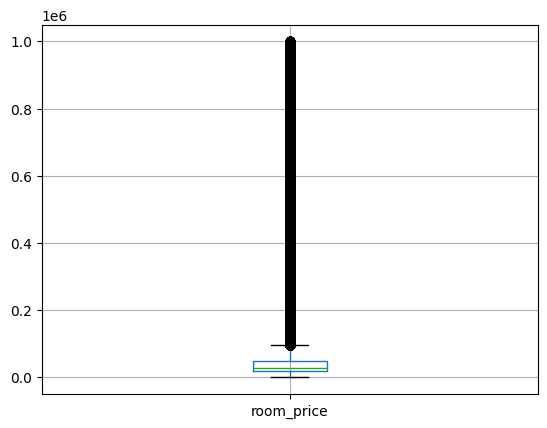

In [141]:
df_flats["room_price"] = df_flats["price"] / df_flats["room_count"]
df_flats[df_flats["room_price"] < 1e6 ].boxplot(column="room_price")
df_flats = df_flats[df_flats["room_price"] < 1e6]

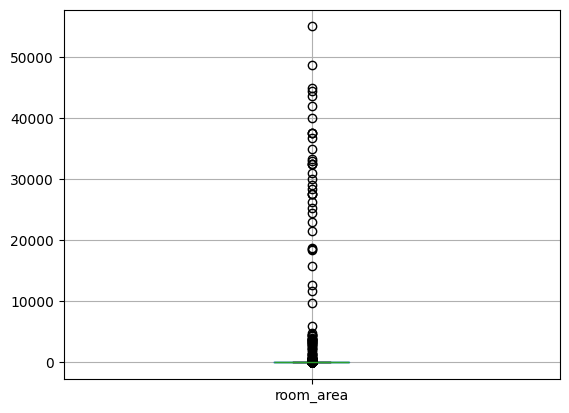

In [142]:
df_flats["room_area"] = df_flats["area_total"] / df_flats["room_count"]

df_flats[df_flats["room_area"] < 60000 ].boxplot(column="room_area")

df_flats = df_flats[df_flats["room_area"] < 300]

In [143]:
df_flats = df_flats[(df_flats["area_total"] < df_flats["area_kitchen"]) & (df_flats["area_total"] > df_flats["area_living"])]

In [144]:
df_flats = df_flats[df_flats["ceiling_height"] < 5]

In [145]:
df_flats.describe()

,Unnamed: 0,price,room_count,floor_count,floor,area_total,area_kitchen,area_living,ceiling_height,price_UAH,room_price,room_area
count,7.000000e+00,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000e+00,7.000000,7.000000
mean,5.462506e+05,114741.142857,2.571429,14.142857,7.857143,75.914286,173.775714,45.848571,2.842857,2.846728e+06,45703.904762,30.259524
std,4.130270e+05,98091.360726,0.975900,7.174691,5.241774,30.332350,113.386281,14.748464,0.151186,2.433647e+06,42574.474652,7.213682
min,5.765400e+04,24300.000000,1.000000,6.000000,1.000000,30.400000,72.700000,23.100000,2.700000,6.028830e+05,15966.666667,18.333333
25%,2.862995e+05,52350.000000,2.000000,9.500000,4.500000,60.500000,99.000000,38.550000,2.700000,1.298804e+06,22150.000000,27.291667
50%,5.071840e+05,60000.000000,3.000000,12.000000,7.000000,73.000000,156.430000,40.000000,2.800000,1.488600e+06,28400.000000,30.400000
75%,7.371520e+05,170000.000000,3.000000,19.000000,11.000000,93.000000,195.550000,58.650000,3.000000,4.217700e+06,47083.333333,34.000000
max,1.212013e+06,274188.000000,4.000000,24.000000,16.000000,121.000000,398.200000,63.440000,3.000000,6.802604e+06,137094.000000,40.500000


Запропонований датасет - зріз оголошень за певний період. Звісно, що чим старше оголошення, тим більша імовірність, що обʼєкт таки продадуть. А чи можете ви спробувати знайти медіанний вік оголошення? Спершу "статистично", потім графічно :)


In [146]:
group_cols = [col for col in df_flats.columns if (col != "download_time") & (col != "Unnamed: 0")]

df_result = df_flats.groupby(group_cols, dropna=False)["download_time"].max().reset_index()

df_result.shape

(7, 16)

In [154]:
df_result["time"] = pd.to_datetime(df_result["download_time"]) - pd.to_datetime(df_result["insert_time"])

UFuncTypeError: ufunc 'less' did not contain a loop with signature matching types (<class 'numpy.dtypes.TimeDelta64DType'>, <class 'numpy.dtypes._PyFloatDType'>) -> None

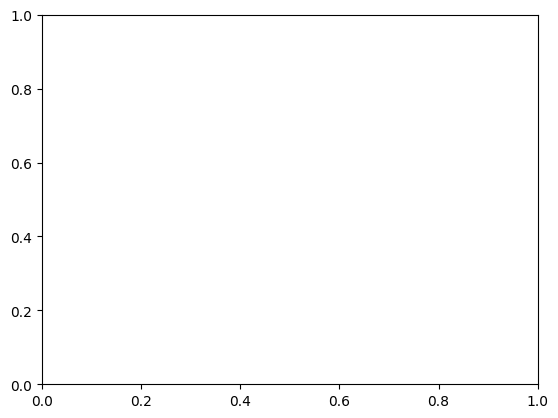

In [155]:
plt.hist(df_result["time"], bins=20)
plt.axvline(df_result["time"].median(), color="red")
plt.axvline(df_result["time"].mean(), color="orange")

Нарешті, ще одне завдання. Використовуючи будь-який підхід, який вам до вподоби (звичайні функції, регулярні вирази тощо), спробуйте виділити з колонки гео дані про місто, а в ідеалі ще номер будинку і вулицю. Задача зовсім не легка, тому можете сконцентруватися на Києві, Харкові та Львові. 

Спробуйте проітеруватися над вашим алгоритмом декілька разів і перевірити, чи адекватні ті дані, які ви отримуєте.
І ще одне: тут немає мети виділити правильне місто зі 100% оголошень. У деяких ситуаціях цілком ок принести в жертву деяку кількість записів, якщо алгоритм при цьому буде достатньо простим.

In [152]:
# df_result["geo"].iloc[1].split(',')

def extract_data(row:str, idx):
    geo = row["geo"].split(',')
    row = row.split(',')
    if len(geo) > idx:
        return geo[idx]
    else:
        return None
    
df_result["city"] = df_result.apply(lambda x: extract_data(x,1), axis=1)
df_result["street"] = df_result.apply(lambda x: extract_data(x, 3), axis=1)
df_result["number"] = df_result.apply(lambda x: extract_data(x, 4), axis=1)
df_result["city"].unique()

AttributeError: 'Series' object has no attribute 'split'